# In Depth A/B Testing - Lab

## Introduction

In this lab, you'll explore a survey from Kaggle regarding budding data scientists. With this, you'll form some initial hypotheses, and test them using the tools you've acquired to date. 

## Objectives

You will be able to:
* Conduct t-tests and an ANOVA on a real-world dataset and interpret the results

## Load the Dataset and Perform a Brief Exploration

The data is stored in a file called **multipleChoiceResponses_cleaned.csv**. Feel free to check out the original dataset referenced at the bottom of this lab, although this cleaned version will undoubtedly be easier to work with. Additionally, meta-data regarding the questions is stored in a file name **schema.csv**. Load in the data itself as a Pandas DataFrame, and take a moment to briefly get acquainted with it.

> Note: If you can't get the file to load properly, try changing the encoding format as in `encoding='latin1'`

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.power import TTestIndPower
import seaborn as sns
import warnings
import flatiron_stats as fts
import statsmodels.api as sm
from statsmodels.formula.api import ols

%matplotlib inline

In [3]:
schema = pd.read_csv('schema.csv', encoding='latin1')
df = pd.read_csv('multipleChoiceResponses_cleaned.csv', encoding='latin1')

In [17]:
df['FormalEducation'].unique()

array(["Bachelor's degree", "Master's degree", 'Doctoral degree', nan,
       "Some college/university study without earning a bachelor's degree",
       'I did not complete any formal education past high school',
       'Professional degree', 'I prefer not to answer'], dtype=object)

## Wages and Education

You've been asked to determine whether education is impactful to salary. Develop a hypothesis test to compare the salaries of those with Master's degrees to those with Bachelor's degrees. Are the two statistically different according to your results?

> Note: The relevant features are stored in the 'FormalEducation' and 'AdjustedCompensation' features.

You may import the functions stored in the `flatiron_stats.py` file to help perform your hypothesis tests. It contains the stats functions that you previously coded: `welch_t(a,b)`, `welch_df(a, b)`, and `p_value(a, b, two_sided=False)`. 

Note that `scipy.stats.ttest_ind(a, b, equal_var=False)` performs a two-sided Welch's t-test and that p-values derived from two-sided tests are two times the p-values derived from one-sided tests. See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) for more information.    

In [4]:
#dataframes based on education
df_bachelor = df[df['FormalEducation'] == "Bachelor's degree"]
df_master = df[df['FormalEducation'] == "Master's degree"]
df_doctor = df[df['FormalEducation'] == "Doctoral degree"]

#dropping NaN values in compensation column
df_bachelor = df_bachelor.dropna(subset=['AdjustedCompensation'])
df_master = df_master.dropna(subset=['AdjustedCompensation'])
df_doctor = df_doctor.dropna(subset=['AdjustedCompensation'])

#filter out excessively high values (north of 1 million) and low values (below federal minimum wage)
df_bachelor = df_bachelor[(df_bachelor['AdjustedCompensation'] <= 999999) & (df_bachelor['AdjustedCompensation'] > 0)] 
df_master = df_master[(df_master['AdjustedCompensation'] <= 999999) & (df_master['AdjustedCompensation'] > 0)] 
df_doctor = df_doctor[(df_doctor['AdjustedCompensation'] <= 999999) & (df_doctor['AdjustedCompensation'] > 0)] 

In [165]:
#performing statistical analysis
t = fts.welch_t(df_bachelor['AdjustedCompensation'], df_master['AdjustedCompensation'])
ddof = fts.welch_df(df_bachelor['AdjustedCompensation'], df_master['AdjustedCompensation'])
p_val = fts.p_value_welch_ttest(df_bachelor['AdjustedCompensation'], df_master['AdjustedCompensation'], two_sided=True)

t2 = stats.ttest_ind(df_bachelor['AdjustedCompensation'], df_master['AdjustedCompensation'], equal_var=False, nan_policy = 'omit')

In [173]:
print(f'''the p_value when comparing adjusted compensation between master and bachelor degrees is {p_val}, therefore we reject the null
        
            ''')

the p_value when comparing adjusted compensation between master and bachelor degrees is 1.5863235467428183e-06, therefore we reject the null


## Wages and Education II

Now perform a similar statistical test comparing the AdjustedCompensation of those with Bachelor's degrees and those with Doctorates. If you haven't already, be sure to explore the distribution of the AdjustedCompensation feature for any anomalies. 

Ttest_indResult(statistic=11.76723361673775, pvalue=6.441928921153893e-31)

we discovered several anomolies in the data when viewing the histogram, so we went back and limited our data
            to adjusted incomes under 1 million dollars, and above 0 dollars, we considered limiting it based on
            US Federal Minimum wage, but then we realized this is an international sample, and that metric is irrelevant 
            in many places in the world
       
after polishing the data to be more realistic, we found a p-value 6.4e-31 and therefore rejected the null hypothesis]
        
        


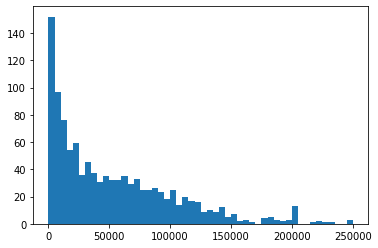

In [184]:
#Your code here
t2 = stats.ttest_ind(df_doctor['AdjustedCompensation'], df_bachelor['AdjustedCompensation'], equal_var=False, nan_policy = 'omit')
p_val2 = fts.p_value_welch_ttest(df_bachelor['AdjustedCompensation'], df_doctor['AdjustedCompensation'], two_sided=True)

print (t2)
print('')
plt.hist(df_bachelor['AdjustedCompensation'], range=[0, 250000], bins=50)

print (f'''we discovered several anomolies in the data when viewing the histogram, so we went back and limited our data
            to adjusted incomes under 1 million dollars, and above 0 dollars, we considered limiting it based on
            US Federal Minimum wage, but then we realized this is an international sample, and that metric is irrelevant 
            in many places in the world
       ''')

print(f"""after polishing the data to be more realistic, we found a p-value 6.4e-31 and therefore rejected the null hypothesis]
        
        """)

## Wages and Education III

Remember the multiple comparisons problem; rather than continuing on like this, perform an ANOVA test between the various 'FormalEducation' categories and their relation to 'AdjustedCompensation'.

In [192]:
df = df[(df['AdjustedCompensation'] <= 999999) & (df['AdjustedCompensation'] > 0)]

formula = "df['AdjustedCompensation'] ~ df['FormalEducation']"
lm = ols(formula, df).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)
print('')
print('we found that the PR(>F) value was 1.08e-30 and therefore we reject the null that education does not affect salary')

                             sum_sq      df          F        PR(>F)
df['FormalEducation']  5.548565e+11     6.0  26.127919  1.082559e-30
Residual               1.515907e+13  4283.0        NaN           NaN

we found that the PR(>F) value was 1.08e-30 and therefore we reject the null that education does not affect salary


## Additional Resources

Here's the original source where the data was taken from:  
    [Kaggle Machine Learning & Data Science Survey 2017](https://www.kaggle.com/kaggle/kaggle-survey-2017)

## Summary

In this lab, you practiced conducting actual hypothesis tests on actual data. From this, you saw how dependent results can be on the initial problem formulation, including preprocessing!